In [8]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

import pandas as pd
from src.location.location import Location, ETAB_NAMES
from src.features.hospital_features import HospitalFeatures
from src.features.meteorological_features import MeteorologicalFeatures
from pathlib import Path
from typing import List

In [9]:
start_date = "2019-01-01"
end_date = "2023-12-31"
DATA_DIR = Path('../data/features/')
EXOGENOUS = False

etab = "CHU Dijon" # ETAB_NAMES[0][1]

date_range = pd.date_range(start=start_date, end=end_date, freq='D').normalize()
df = pd.DataFrame({'date': date_range})
df.set_index('date', inplace=True)
loc = Location(etab)
features = [HospitalFeatures(name='hospitalfeatures', include_hnfc_moving=False, include_nb_hospit=False), 
            # MeteorologicalFeatures(name='meteorologicalfeatures')
            ]

for feature in features:
    df_temp = feature.fetch_data_function(location=loc, feature_dir=DATA_DIR / feature.name, start_date=start_date, stop_date=end_date)
    #df_temp.index.normalize()
    # print(df_temp)
    df = pd.merge(df, df_temp, how='left', left_index=True, right_index=True)


In [10]:
df

,nb_emmergencies
date,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-05,NaN
...,...
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN


In [11]:
def categorize(df, column, bins=[0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0], labels=None, drop=False):
    if labels == None and type(bins) == int:
        labels = [f'{i}' for i in range(bins)]
    elif labels == None and type(bins) == list:
        labels = [f'{i}' for i in range(len(bins) - 1)]
    col_category = (column if drop else f'{column}_category')
    df[col_category] = pd.qcut(df[column], q=bins, labels=labels)
    return df

In [12]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Discretize with different numbers of quantiles
def calculate_mutual_info(df, target_column, n_quantiles):
    df[f'{target_column}_category'] = pd.qcut(df[target_column], q=n_quantiles, labels=False)
    mi = mutual_info_classif(df.drop(columns=[target_column, f'{target_column}_category']), df[f'{target_column}_category'])
    return mi.mean()

if len(features) > 1:
    best_score = (0, 0)
    # Example to try quantiles from 2 to 10
    for q in range(2, 11):
        mi_score = calculate_mutual_info(df, f'nb_emmergencies_{etab}', q)
        if mi_score > best_score[1]:
            best_score = (q, mi_score)
        print(f'Quantiles: {q}, Avg MI score: {mi_score:.4f}')
    print(f'Best quantiles: {best_score[0]}, Best MI score: {best_score[1]:.4f}')
else:
    best_score = (4, 0)

In [13]:
# bins = best_score[0]
#bins = [0, 0.2, 0.7, 1.0] # Define custom quantiles for 20%, 50%, and 30% bins
bins = [0, 0.1, 0.3, 0.7, 0.9, 0.97, 1.0]

In [14]:
df = categorize(df, f'nb_emmergencies_{etab}', bins=bins, drop=False)

KeyError: 'nb_emmergencies_CHU Dijon'

In [ ]:
df


NameError: name 'df' is not defined

In [ ]:
target_col = f'nb_emmergencies_{etab}'
category_col = f'{target_col}_category'
# category_col = target_col

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=category_col, y=target_col, data=df, palette='Set3')
plt.xlabel('Quantile')
plt.ylabel('Target Value')
plt.title('Target Value Distribution Across Quantiles')
plt.show()


ValueError: Could not interpret value `nb_emmergencies_CHU Dijon_category` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x500 with 0 Axes>

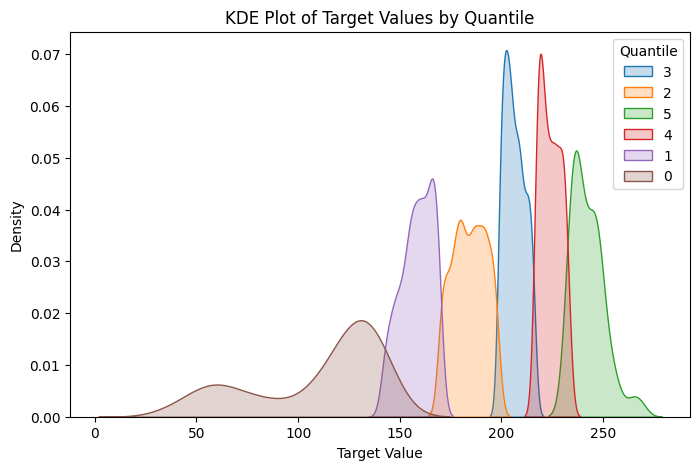

In [ ]:
plt.figure(figsize=(8, 5))
for quantile in df[category_col].unique():
    sns.kdeplot(df[df[category_col] == quantile][target_col], label=f'{quantile}', fill=True)
plt.xlabel('Target Value')
plt.title('KDE Plot of Target Values by Quantile')
plt.legend(title='Quantile')
plt.show()


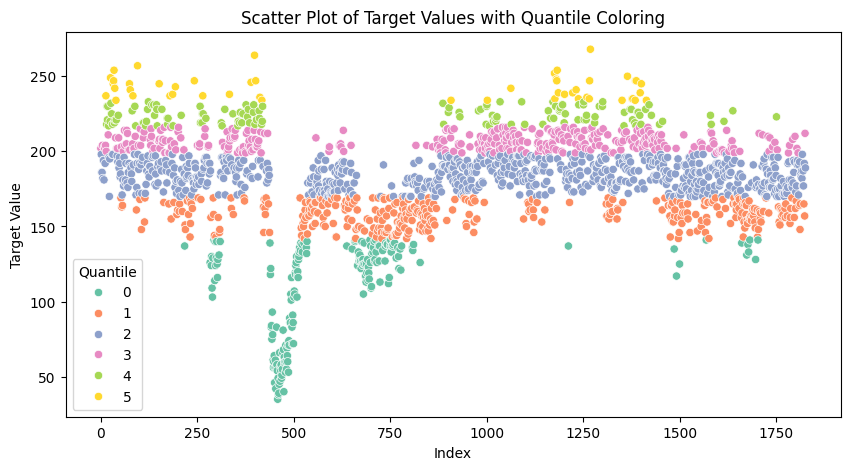

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(df)), y=target_col, hue=category_col, data=df, palette='Set2')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.title('Scatter Plot of Target Values with Quantile Coloring')
plt.legend(title='Quantile')
plt.show()
